# Vertex Buffers

**Vertex declaration, vertex bindings, index buffer**

In this example, we demonstrate how to work with vertex buffers in Vulky. This includes:

- Creating and loading vertex buffer data  
- Declaring vertex attributes (locations) in the pipeline  
- Specifying vertex bindings (if statically defined in the pipeline)  
- Binding vertex and index buffers using the command manager before issuing a draw call

This process is similar to the previous example, but now focuses on setting up data for rendering geometry.


In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav==13.1.0
    !pip install git+https://github.com/rendervous/vulky_project.git
except:
    print("Executing locally")

Executing locally


In [2]:
import vulky as vk
import torch
vk.create_device(debug=True)
SCREEN_WIDTH = 512
SCREEN_HEIGHT = 512
render_target = vk.render_target(
    image_format=vk.Format.VEC4,
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)
depth_buffer = vk.depth_stencil(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)

[INFO] Debug instance created...
[PRINT] Inserted device layer "VK_LAYER_KHRONOS_validation" (C:\VulkanSDK\1.3.275.0\Bin\.\VkLayer_khronos_validation.dll)
[PRINT] Inserted device layer "VK_LAYER_OBS_HOOK" (C:\ProgramData\obs-studio-hook\.\graphics-hook64.dll)
[PRINT] Inserted device layer "VK_LAYER_NV_optimus" (C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll)
[PRINT] vkCreateDevice layer callstack setup to:
[PRINT]    <Application>
[PRINT]      ||
[PRINT]    <Loader>
[PRINT]      ||
[PRINT]    VK_LAYER_NV_optimus
[PRINT]            Type: Implicit
[PRINT]                Disable Env Var:  DISABLE_LAYER_NV_OPTIMUS_1
[PRINT]            Manifest: C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\nv-vk64.json
[PRINT]            Library:  C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll
[PRINT]      ||
[PRINT]    VK_LAYER_OBS_HOOK
[PRINT]            Type: Implici

In [3]:
vertex_buffer = vk.vertex_buffer(4, element_description=dict(
    P=vk.vec3,
    C=vk.vec2
))

In [4]:
with vertex_buffer.map(mode='in') as vb:
    vb.P = [
        [-.9, -.9, 0.5],
        [.9, -.9, 0.5],
        [.9, .9, 0.5],
        [-.9, .9, 0.5]
    ]
    vb.C = [
        [0.0, 0.0],
        [1.0, 0.0],
        [1.0, 1.0],
        [0.0, 1.0]
    ]

In [5]:
index_buffer = vk.index_buffer(6)
index_buffer.load([0, 1, 2, 0, 2, 3])

tensor([0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0],
       device='cuda:0', dtype=torch.uint8)

In [6]:
vertex_shader_code = """
#version 450
#extension GL_EXT_scalar_block_layout: enable

layout(location = 0) in vec3 in_position;
layout(location = 1) in vec2 in_coordinates;
layout(location = 0) out vec2 out_coordinates;

void main()
{
    gl_Position = vec4(in_position, 1.0);
    out_coordinates = in_coordinates;
}
"""
fragment_shader_code = """
#version 450
layout(location = 0) in vec2 in_coordinates;
layout(location = 0) out vec4 out_color;
void main() {
    out_color = vec4(in_coordinates.x, in_coordinates.y, 1.0, 1.0);
}
"""

In [7]:
pipeline = vk.pipeline_graphics()
pipeline.attach(slot=0, render_target=vk.Format.VEC4)
pipeline.attach(slot=1, depth_buffer=vk.Format.DEPTH_STENCIL)

In [8]:
pipeline.vertex(location=0, in_position=vk.Format.VEC3)
pipeline.vertex(location=1, in_coordinates=vk.Format.VEC2)
pipeline.vertex_binding(
    binding=0,
    stride=(3+2)*4,
    in_position=0,
    in_coordinates=3*4,
)

In [9]:
with pipeline.shader_stages(vk.ShaderStage.VERTEX):
    pipeline.load_shader_from_source(vertex_shader_code)
with pipeline.shader_stages(vk.ShaderStage.FRAGMENT):
    pipeline.load_shader_from_source(fragment_shader_code)
pipeline.close()  # This creates the internal pipeline object and bindings

In [10]:
framebuffer = pipeline.create_framebuffer(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT,
    render_target=render_target,
    depth_buffer=depth_buffer
)

In [11]:
man = vk.graphics_manager()
man.clear_color(render_target, (0.0, 0.0, 0.5, 1.0))
man.clear_depth_stencil(depth_buffer, 1.0, 0)
man.set_pipeline(pipeline)
man.set_framebuffer(framebuffer)

In Vulkan, the NDC (Normalized Device Coordinates) space is aligned with the framebuffer. This means that the default viewport would map the NDC's negative corner `(-1, -1)` to pixel coordinate `(0, 0)`, and the positive corner `(1, 1)` to `(width, height)`.

As a result, the **Y-axis increases downward**, which matches the typical convention for images, but appears flipped compared to traditional rendering conventions (like OpenGL), where Y increases upward.

This flip is purely a consequence of the viewport transformation and does **not** affect the camera's intrinsic or extrinsic matrices — those remain agnostic of framebuffer orientation.

One common way to handle this Y-axis inversion is by configuring the viewport with a negative scale on Y and adjusting the origin accordingly, for example:
- Set `viewport.height` to a **negative value**
- Set `viewport.y` to the **framebuffer height**

This effectively flips the rendering along Y without modifying the projection matrix.


In [ ]:
man.set_viewport(0.0, framebuffer.height, framebuffer.width, -framebuffer.height)

In [12]:
man.bind_vertex_buffer(0, vertex_buffer)
man.bind_index_buffer(index_buffer)
man.dispatch_indexed_primitives(6)
man.freeze()

vk.submit(man)

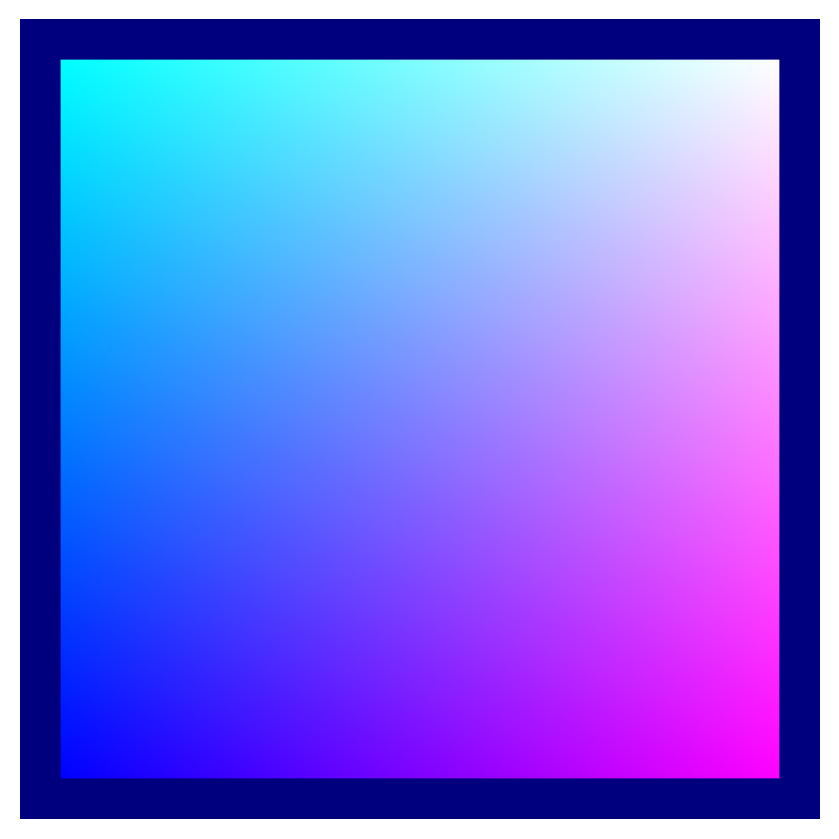

In [13]:
staging = vk.tensor(render_target.height, render_target.width, 4)
render_target.save(staging)
import matplotlib.pyplot as plt
# visualize the tensor with matplotlib
plt.figure(figsize=(4,4), dpi=200)
plt.imshow(staging.cpu())
plt.gca().axis('off')
plt.tight_layout(pad=0.0)
plt.savefig('teaser4.jpg')
plt.show()